In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# pip install  scikit-learn 

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
df = pd.read_excel("reviews_all.xlsx")
df

,review,sentiment
0,Парковки нет,negative
1,Карак чай не похож ни на дубайский ни на оманс...,negative
2,"Очень люблю карак чай, но когда его быстро-быс...",positive
3,"Горячие напитки у вас отличные, очень нравятся...",positive
4,Любителям чая и вкусных закусок посвящается! С...,positive
...,...,...
2045,"Обслуживание 0, оффицианты подошли минут через 30",negative
2046,Тармақтарында тұз жоқ. Гигиенасы да дұрыс емес.,negative
2047,Одна звезда это очень много для этого заведени...,negative
2048,"Обслуживание, не о чем.",negative


In [5]:
df["sentiment"] = df["sentiment"].apply(lambda x : x.strip())


In [6]:
df["sentiment"] = df["sentiment"].replace(r'^neutral$',np.nan, regex=True)
df = df.dropna().reset_index(drop=True)

In [7]:
df

,review,sentiment
0,Парковки нет,negative
1,Карак чай не похож ни на дубайский ни на оманс...,negative
2,"Очень люблю карак чай, но когда его быстро-быс...",positive
3,"Горячие напитки у вас отличные, очень нравятся...",positive
4,Любителям чая и вкусных закусок посвящается! С...,positive
...,...,...
1995,"Обслуживание 0, оффицианты подошли минут через 30",negative
1996,Тармақтарында тұз жоқ. Гигиенасы да дұрыс емес.,negative
1997,Одна звезда это очень много для этого заведени...,negative
1998,"Обслуживание, не о чем.",negative


In [8]:
df['sentiment'].unique()

array(['negative', 'positive'], dtype=object)

In [9]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (1500,)
shape of test data is (500,)


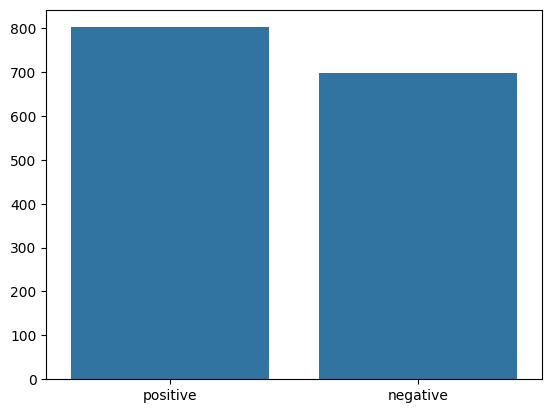

positive    802
negative    698
Name: count, dtype: int64

In [10]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['positive','negative']),y=dd.values)
plt.show()
dd

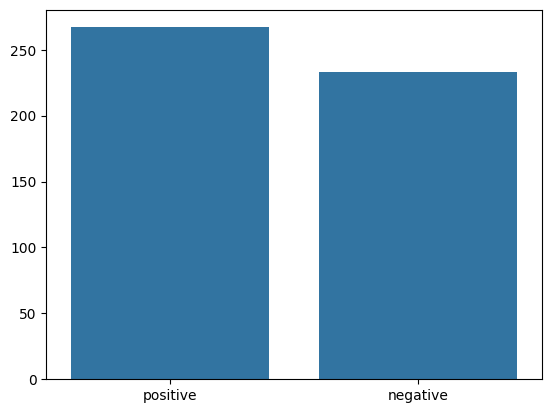

positive    267
negative    233
Name: count, dtype: int64

In [11]:
dd = pd.Series(y_test).value_counts()
sns.barplot(x=np.array(['positive',"negative"]),y=dd.values)
plt.show()
dd

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('russian')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train, dtype=object), np.array(encoded_train), \
       np.array(final_list_test, dtype=object), np.array(encoded_test), onehot_dict



In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [14]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

In [15]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


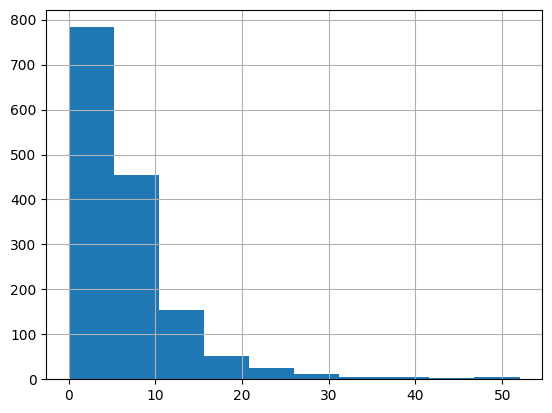

count    1500.000000
mean        6.786000
std         6.382949
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        52.000000
dtype: float64

In [16]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [17]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [18]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [19]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [20]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 476,  35, 550],
        [  0,   0,   0,  ...,  69, 148, 584],
        [  0,   0,   0,  ...,   0,   3, 107],
        ...,
        [  0,   0,   0,  ..., 116, 213, 226],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,  13,  12,  75]])
Sample input: 
 tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1])


In [21]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [22]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [23]:
from torchinfo import summary
# do a test pass through of an example input size 
summary(model) 

Layer (type:depth-idx)                   Param #
SentimentRNN                             --
├─Embedding: 1-1                         64,064
├─LSTM: 1-2                              856,064
├─Dropout: 1-3                           --
├─Linear: 1-4                            257
├─Sigmoid: 1-5                           --
Total params: 920,385
Trainable params: 920,385
Non-trainable params: 0

In [24]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [28]:
clip = 5
epochs = 10
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.13691566673417885 val_loss : 0.36230929791927335
train_accuracy : 94.26666666666667 val_accuracy : 86.8
Validation loss decreased (inf --> 0.362309).  Saving model ...
Epoch 2
train_loss : 0.12162094097584486 val_loss : 0.3592414975166321
train_accuracy : 93.73333333333333 val_accuracy : 83.39999999999999
Validation loss decreased (0.362309 --> 0.359241).  Saving model ...
Epoch 3
train_loss : 0.1078090434273084 val_loss : 0.4610667794942856
train_accuracy : 95.46666666666667 val_accuracy : 83.2
Epoch 4
train_loss : 0.07648665253072977 val_loss : 0.4381221145391464
train_accuracy : 96.33333333333334 val_accuracy : 85.2
Epoch 5
train_loss : 0.06136009516194463 val_loss : 0.48658752292394636
train_accuracy : 96.8 val_accuracy : 86.2
Epoch 6
train_loss : 0.05639984337612987 val_loss : 0.5064837627112866
train_accuracy : 97.06666666666666 val_accuracy : 85.6
Epoch 7
train_loss : 0.05393246356397867 val_loss : 0.510864619165659
train_accuracy : 97.26666666666667 val_a

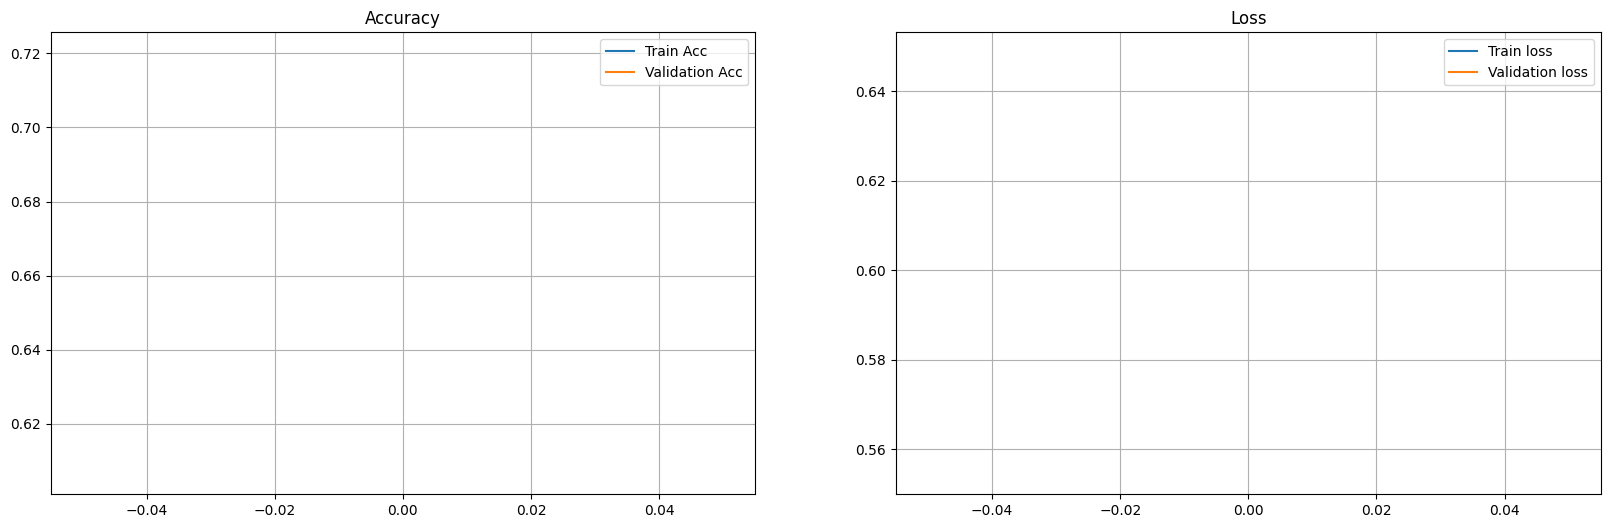

In [26]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [ ]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')


In [ ]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')